**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 500 
h1_dim = 250
z_dim = 2 
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=500, h1_dim=250, z_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h1_dim)
        self.fc3 = nn.Linear(h1_dim, z_dim)
        self.fc4 = nn.Linear(h1_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, h_dim)
        self.fc7 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h), self.fc4(h)
    
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        return F.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 35335.0469, KL Div: 1023.8227
Epoch[1/15], Step [20/469], Reconst Loss: 27647.2031, KL Div: 116.4380
Epoch[1/15], Step [30/469], Reconst Loss: 27470.2715, KL Div: 79.3406
Epoch[1/15], Step [40/469], Reconst Loss: 26631.3672, KL Div: 114.7342
Epoch[1/15], Step [50/469], Reconst Loss: 25980.7227, KL Div: 267.4141
Epoch[1/15], Step [60/469], Reconst Loss: 24621.8555, KL Div: 430.3017
Epoch[1/15], Step [70/469], Reconst Loss: 25711.7539, KL Div: 251.0403
Epoch[1/15], Step [80/469], Reconst Loss: 24107.7988, KL Div: 338.8414
Epoch[1/15], Step [90/469], Reconst Loss: 24510.6406, KL Div: 312.5255
Epoch[1/15], Step [100/469], Reconst Loss: 23196.8398, KL Div: 338.1339
Epoch[1/15], Step [110/469], Reconst Loss: 24400.5742, KL Div: 326.3906
Epoch[1/15], Step [120/469], Reconst Loss: 23252.4297, KL Div: 382.3168
Epoch[1/15], Step [130/469], Reconst Loss: 23451.5645, KL Div: 361.7078
Epoch[1/15], Step [140/469], Reconst Loss: 23627.1484, KL Div: 507.3534
E

Epoch[3/15], Step [240/469], Reconst Loss: 19778.5938, KL Div: 695.4447
Epoch[3/15], Step [250/469], Reconst Loss: 19723.9922, KL Div: 725.3378
Epoch[3/15], Step [260/469], Reconst Loss: 19131.8398, KL Div: 753.4662
Epoch[3/15], Step [270/469], Reconst Loss: 18974.3457, KL Div: 697.8180
Epoch[3/15], Step [280/469], Reconst Loss: 19338.3867, KL Div: 755.0405
Epoch[3/15], Step [290/469], Reconst Loss: 18937.1328, KL Div: 775.7693
Epoch[3/15], Step [300/469], Reconst Loss: 19305.3379, KL Div: 778.1754
Epoch[3/15], Step [310/469], Reconst Loss: 18963.8086, KL Div: 754.4852
Epoch[3/15], Step [320/469], Reconst Loss: 19787.0645, KL Div: 709.2451
Epoch[3/15], Step [330/469], Reconst Loss: 19613.8887, KL Div: 787.7589
Epoch[3/15], Step [340/469], Reconst Loss: 18758.3379, KL Div: 781.2476
Epoch[3/15], Step [350/469], Reconst Loss: 19054.8066, KL Div: 744.0283
Epoch[3/15], Step [360/469], Reconst Loss: 18570.3672, KL Div: 760.1747
Epoch[3/15], Step [370/469], Reconst Loss: 18553.7344, KL Div: 7

Epoch[6/15], Step [10/469], Reconst Loss: 18865.0156, KL Div: 774.3605
Epoch[6/15], Step [20/469], Reconst Loss: 18584.3359, KL Div: 793.2012
Epoch[6/15], Step [30/469], Reconst Loss: 17678.3164, KL Div: 790.1575
Epoch[6/15], Step [40/469], Reconst Loss: 17892.0586, KL Div: 754.7994
Epoch[6/15], Step [50/469], Reconst Loss: 17901.3633, KL Div: 777.6213
Epoch[6/15], Step [60/469], Reconst Loss: 17352.2832, KL Div: 796.4593
Epoch[6/15], Step [70/469], Reconst Loss: 17442.6582, KL Div: 806.9035
Epoch[6/15], Step [80/469], Reconst Loss: 18255.5781, KL Div: 797.5420
Epoch[6/15], Step [90/469], Reconst Loss: 18330.3750, KL Div: 786.3071
Epoch[6/15], Step [100/469], Reconst Loss: 18034.8008, KL Div: 757.1923
Epoch[6/15], Step [110/469], Reconst Loss: 18987.7188, KL Div: 793.3572
Epoch[6/15], Step [120/469], Reconst Loss: 17894.5820, KL Div: 770.6699
Epoch[6/15], Step [130/469], Reconst Loss: 17841.5117, KL Div: 801.4241
Epoch[6/15], Step [140/469], Reconst Loss: 17954.5605, KL Div: 756.0327
E

Epoch[8/15], Step [240/469], Reconst Loss: 17239.7227, KL Div: 788.0681
Epoch[8/15], Step [250/469], Reconst Loss: 18345.4180, KL Div: 791.9069
Epoch[8/15], Step [260/469], Reconst Loss: 16482.9492, KL Div: 801.3456
Epoch[8/15], Step [270/469], Reconst Loss: 17651.7910, KL Div: 812.0642
Epoch[8/15], Step [280/469], Reconst Loss: 18315.3164, KL Div: 788.7615
Epoch[8/15], Step [290/469], Reconst Loss: 18087.1992, KL Div: 822.9069
Epoch[8/15], Step [300/469], Reconst Loss: 17250.5312, KL Div: 785.8392
Epoch[8/15], Step [310/469], Reconst Loss: 17670.5488, KL Div: 763.6676
Epoch[8/15], Step [320/469], Reconst Loss: 17827.9199, KL Div: 838.1204
Epoch[8/15], Step [330/469], Reconst Loss: 18053.0645, KL Div: 814.2561
Epoch[8/15], Step [340/469], Reconst Loss: 18242.0840, KL Div: 815.0740
Epoch[8/15], Step [350/469], Reconst Loss: 17720.4922, KL Div: 811.8716
Epoch[8/15], Step [360/469], Reconst Loss: 17842.5352, KL Div: 838.1132
Epoch[8/15], Step [370/469], Reconst Loss: 17739.5586, KL Div: 8

Epoch[10/15], Step [460/469], Reconst Loss: 18364.3691, KL Div: 820.6903
Epoch[11/15], Step [10/469], Reconst Loss: 17745.5645, KL Div: 858.0668
Epoch[11/15], Step [20/469], Reconst Loss: 17565.0840, KL Div: 828.6566
Epoch[11/15], Step [30/469], Reconst Loss: 17774.8867, KL Div: 831.8007
Epoch[11/15], Step [40/469], Reconst Loss: 16435.8320, KL Div: 816.3053
Epoch[11/15], Step [50/469], Reconst Loss: 18091.5410, KL Div: 825.1213
Epoch[11/15], Step [60/469], Reconst Loss: 17756.3555, KL Div: 849.4228
Epoch[11/15], Step [70/469], Reconst Loss: 17374.0762, KL Div: 813.1336
Epoch[11/15], Step [80/469], Reconst Loss: 18007.2188, KL Div: 844.3140
Epoch[11/15], Step [90/469], Reconst Loss: 16514.0605, KL Div: 820.1714
Epoch[11/15], Step [100/469], Reconst Loss: 18220.7637, KL Div: 809.2561
Epoch[11/15], Step [110/469], Reconst Loss: 17108.3125, KL Div: 814.8371
Epoch[11/15], Step [120/469], Reconst Loss: 17552.8398, KL Div: 824.6027
Epoch[11/15], Step [130/469], Reconst Loss: 17257.7031, KL D

Epoch[13/15], Step [210/469], Reconst Loss: 17200.6367, KL Div: 828.0812
Epoch[13/15], Step [220/469], Reconst Loss: 17585.5781, KL Div: 829.1111
Epoch[13/15], Step [230/469], Reconst Loss: 17226.9297, KL Div: 813.3052
Epoch[13/15], Step [240/469], Reconst Loss: 17081.8672, KL Div: 845.5078
Epoch[13/15], Step [250/469], Reconst Loss: 17298.5918, KL Div: 819.3851
Epoch[13/15], Step [260/469], Reconst Loss: 17397.5254, KL Div: 829.6760
Epoch[13/15], Step [270/469], Reconst Loss: 17215.1211, KL Div: 858.0451
Epoch[13/15], Step [280/469], Reconst Loss: 18419.1211, KL Div: 835.8488
Epoch[13/15], Step [290/469], Reconst Loss: 17869.4336, KL Div: 829.0134
Epoch[13/15], Step [300/469], Reconst Loss: 17174.3457, KL Div: 842.1050
Epoch[13/15], Step [310/469], Reconst Loss: 16506.6699, KL Div: 837.6124
Epoch[13/15], Step [320/469], Reconst Loss: 17817.1367, KL Div: 834.8684
Epoch[13/15], Step [330/469], Reconst Loss: 17973.5312, KL Div: 822.5660
Epoch[13/15], Step [340/469], Reconst Loss: 17075.9

Epoch[15/15], Step [420/469], Reconst Loss: 16919.2949, KL Div: 829.6753
Epoch[15/15], Step [430/469], Reconst Loss: 17458.8945, KL Div: 837.4960
Epoch[15/15], Step [440/469], Reconst Loss: 17992.9023, KL Div: 853.8102
Epoch[15/15], Step [450/469], Reconst Loss: 17292.8906, KL Div: 836.6005
Epoch[15/15], Step [460/469], Reconst Loss: 17310.3633, KL Div: 842.1627


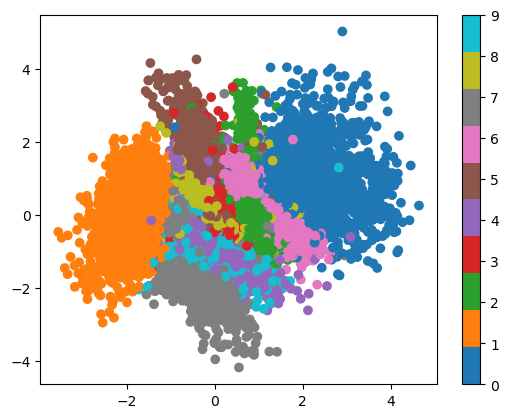

In [6]:
import matplotlib.pyplot as plt

new_data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

for i, (x, y) in enumerate(new_data_loader):
        #print(x)
        x=x.view(-1, image_size)
        #print(x)
        t = model.reparameterize(model.encode(x.to(device))[0], model.encode(x.to(device))[1])
        t = t.to(device).detach().numpy()
        plt.scatter(t[:, 0], t[:, 1], c=y, cmap='tab10')
        if i > batch_size:
            plt.colorbar()
            break

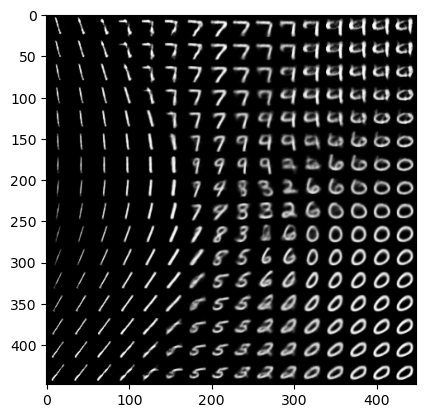

In [7]:
values = np.arange(-4, 4, .5)
xx, yy = np.meshgrid(values, values)
point = np.zeros((1, 2))
# Matrix that will contain the grid of images
container = np.zeros((28 * len(values), 28 * len(values))) #392*392, 392 = 28*14



test_data_loader = torch.utils.data.DataLoader(dataset=dataset,
shuffle=True)

for row in range(xx.shape[0]):
    for col in range(xx.shape[1]):
        point[0, :] = [xx[row, col], yy[row, col]]
        #print(type(input_holder))
        #torch.from_numpy(input_holder[0, :])
        #print(type(input_holder[0, :]))
        model.decode(torch.from_numpy(point[0, :]).float())
        #(artificial_image,_) = next(iter(test_data_loader))
        new_image = model.decode(torch.from_numpy(point[0, :]).float())
        new_image = new_image.detach().numpy()
        #artificial_image = artificial_image.squeeze(dim=0)
        container[row * 28: (row + 1) * 28, col * 28: (col + 1) * 28] = np.reshape(new_image, (28, 28))
plt.imshow(container, cmap='gray')